## $\color{SkyBlue}{\text{Hypothesis 3}}$
#### $\color{SkyBlue}{\text{Cole Krant}}$

### Description

How does the size of the city affect their likelihood of winning? (larger talent pool)

<br>
<br>

$\rule{27cm}{0.4pt}$ 
### Import Libraries

In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

$\rule{27cm}{0.4pt}$
### K-Means Algorithm

In [3]:
#--------------------------------------------------------------------------------#
def dist(x1, x2):
    return np.sqrt(np.sum(x1-x2)**2)
#--------------------------------------------------------------------------------#

In [4]:
#--------------------------------------------------------------------------------#
def kMeans(df, k=4, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    #---------------------------------------#
    #-- Initialize --#
    clusters = np.zeros(len(df))
    centroids = df.sample(k).values
    mean_error = np.inf
    converged = False
    
    num_iterations = 0
    
    #---------------------------------------#
    #-- LOOP UNTIL CONVERGENCE --#
    while not(converged):
        
        #-- Cluster Assignment --#
        for index, data in enumerate(df.values):
            distances = [dist(data, centroid) for centroid in centroids]
            clusters[index] = np.argmin(distances)
        
        #-- Update Centroids --#
        updated_centroids = np.empty((k, df.shape[1]))
        for index in range(k):
            clust_data = df[clusters == index]
            centroid = clust_data.mean(axis=0)
            updated_centroids[index, :] = centroid
            
        #-- Calculate Meanerror --#
        errors = []
        for data, cluster in zip(df.values, clusters):
            centroid = updated_centroids[int(cluster)]
            errors.append(dist(data, centroid)**2)
        
        error_arr = np.array(errors)
        
        #-- Calculate Reconstruction Error --#
        rec_err = np.sum(error_arr)/len(df)
        
        #-- Check for Convergence --#
        if (abs(rec_err - mean_error) < tol):
            converged = True
                    
        # Update Values
        centroids = updated_centroids
        mean_error = rec_err
        num_iterations = num_iterations + 1
        
    #---------------------------------------#
    return centroids, clusters, mean_error
#--------------------------------------------------------------------------------#

$\rule{27cm}{0.4pt}$ 
### Dataframe Composition

In [15]:
#--------------------------------------------------------------------------------#
## Population Dataframe
#  Import wage_population.csv
#  Get the columns 'City', 'Zipcode', 'EstimatedPopulation', 'TotalWages'
#  Drop any rows with missing values

df_population = pd.read_csv('data/wages_population.csv')
df_population = df_population[['City', 'Zipcode', 'EstimatedPopulation', 'TotalWages']]
df_population = df_population.dropna()
df_population.head()
#--------------------------------------------------------------------------------#

,City,Zipcode,EstimatedPopulation,TotalWages
112,MONITOR,7093,42640.0,1.071976e+09
113,TAURUS,7093,42640.0,1.071976e+09
114,WESTWOOD,7675,24083.0,1.089095e+09
115,OLD TAPPAN,7675,24083.0,1.089095e+09
116,RIVER VALE,7675,24083.0,1.089095e+09


In [11]:
#--------------------------------------------------------------------------------#
## Rankings
#   Abbreviation (id)
#   Rank
#   Year
#   Conference
df_rankings = pd.read_csv("data/rankings.csv")

#-- LOOP: clean the stars from the data --#
for i in range(len(df_rankings)):
    if (df_rankings["Team"].iloc[i].find('*')):
        df_rankings["Team"].iloc[i] = df_rankings["Team"].iloc[i].replace('*', '')

df_rankings = df_rankings[(df_rankings["Year"] == 2018) |
                          (df_rankings["Year"] == 2019) |
                          (df_rankings["Year"] == 2020) |
                          (df_rankings["Year"] == 2021) |
                          (df_rankings["Year"] == 2022) ]

print(df_rankings)
#--------------------------------------------------------------------------------#

                      Team  Rank  Year Conference
30            Phoenix Suns     1  2022       West
31       Memphis Grizzlies     2  2022       West
32   Golden State Warriors     3  2022       West
33        Dallas Mavericks     4  2022       West
34               Utah Jazz     5  2022       West
..                     ...   ...   ...        ...
175        New York Knicks    11  2018       East
176          Brooklyn Nets    12  2018       East
177          Chicago Bulls    13  2018       East
178          Orlando Magic    14  2018       East
179          Atlanta Hawks    15  2018       East

[150 rows x 4 columns]


In [14]:
#--------------------------------------------------------------------------------#
## Now that we have a dataframe with the team abbreviation, we need to join it with the full name
#    in order to get a rank for that year
df_team = pd.read_csv("data/team.csv")
df_team = df_team[["full_name", "city"]]
df_team.head()

#-------------------------------------------------------------------------------#

,full_name,city
0,Atlanta Hawks,Atlanta
1,Boston Celtics,Boston
2,Cleveland Cavaliers,Cleveland
3,New Orleans Pelicans,New Orleans
4,Chicago Bulls,Chicago


### Dataframe Concatenation

In [52]:
#--------------------------------------------------------------------------------#
### Pseudocode
# Objective: create a dataframe with the following columns
#       Loop through each year
#           Create a smaller dataframe with the given year
#           Loop through each team

# New Master Dataframe
dict = {'Team' : [], 'City' : []}
dfMaster = pd.DataFrame(dict)

# Get all unique years and teams
years = df_players_by_seasons["season"].unique()                    # get all unique years
teams = df_players_by_seasons["team_abbreviation"].unique()       # get all unique teams

##-- Loop through each year --##
for year in range(len(years)):

    # Create a smaller dataframe with the given year
    df_year = df_players_by_seasons[df_players_by_seasons["season"] == years[year]]
    # print(df_year[df_year["team_abbreviation"] == "HOU"])

    ##-- Loop through each team --##
    for team in range(len(teams)):

        # Calculate average height of the team
        avg_height = df_year[df_year["team_abbreviation"] == teams[team]]["player_height"].mean()  # calculate average height of the team
        avg_weight = df_year[df_year["team_abbreviation"] == teams[team]]["player_weight"].mean()  # calculate average height of the team
        avg_weight_lbs = avg_weight*2.20462

        # Append the team, average height, and year to the new dataframe
        temp = {'Team' : teams[team], 'Avg_Height' : avg_height, 'Avg_Weight': avg_weight_lbs, 'Year' : years[year]}             # create a temporary dataframe
        df_temp = pd.DataFrame(temp, index=[0])

        # print(df_temp)

        dfMaster = pd.concat([dfMaster, df_temp], ignore_index = True)                             # append the temporary dataframe to the master dataframe
        dfMaster = dfMaster.reset_index(drop=True)


#--------------------------------------------------------------------------------#
print(dfMaster)

    Team  Avg_Height  Avg_Weight  Year
0    HOU  199.898000  218.899561  2018
1    SAC  200.510588  214.764275  2018
2    NYK  202.154118  223.234847  2018
3    TOR  198.966667  213.888460  2018
4    PHI  202.665263  223.789025  2018
..   ...         ...         ...   ...
145  BKN  198.882000  217.849563  2022
146  LAL  198.402222  208.388471  2022
147  ATL  198.966667  211.721798  2022
148  CLE  198.568235  218.587797  2022
149  CHI  198.867059  213.940748  2022

[150 rows x 4 columns]


In [7]:
#--------------------------------------------------------------------------------#
## Now that we have a dataframe with the team abbreviation, we need to join it with the full name
#    in order to get a rank for that year
df_team = pd.read_csv("data/team.csv")
df_team = df_team[["full_name", "abbreviation"]]
df_team.head()

## add a column to dfMaster that contains the full name of the team, join on abbreviation
dfMaster = dfMaster.merge(df_team, left_on="Team", right_on="abbreviation")
print(dfMaster)

#--------------------------------------------------------------------------------#

    Team  Avg_Height  Avg_Weight  Year        full_name abbreviation
0    HOU  199.898000   99.291289  2018  Houston Rockets          HOU
1    HOU  197.866000   98.610901  2019  Houston Rockets          HOU
2    HOU  197.889091   98.120197  2020  Houston Rockets          HOU
3    HOU  196.532500   97.493930  2021  Houston Rockets          HOU
4    HOU  200.490667  100.757903  2022  Houston Rockets          HOU
..   ...         ...         ...   ...              ...          ...
145  CHI  198.402222   96.287502  2018    Chicago Bulls          CHI
146  CHI  201.108235   99.443376  2019    Chicago Bulls          CHI
147  CHI  199.315294   98.589555  2020    Chicago Bulls          CHI
148  CHI  198.882000   97.499600  2021    Chicago Bulls          CHI
149  CHI  198.867059   97.042006  2022    Chicago Bulls          CHI

[150 rows x 6 columns]


In [8]:
#--------------------------------------------------------------------------------#
## Rankings
#   Abbreviation (id)
#   Rank
#   Year
#   Conference
df_rankings = pd.read_csv("data/rankings.csv")

#-- LOOP: clean the stars from the data --#
for i in range(len(df_rankings)):
    if (df_rankings["Team"].iloc[i].find('*')):
        df_rankings["Team"].iloc[i] = df_rankings["Team"].iloc[i].replace('*', '')

df_rankings = df_rankings[(df_rankings["Year"] == 2018) |
                          (df_rankings["Year"] == 2019) |
                          (df_rankings["Year"] == 2020) |
                          (df_rankings["Year"] == 2021) |
                          (df_rankings["Year"] == 2022) ]

print(df_rankings)
#--------------------------------------------------------------------------------#

                      Team  Rank  Year Conference
30            Phoenix Suns     1  2022       West
31       Memphis Grizzlies     2  2022       West
32   Golden State Warriors     3  2022       West
33        Dallas Mavericks     4  2022       West
34               Utah Jazz     5  2022       West
..                     ...   ...   ...        ...
175        New York Knicks    11  2018       East
176          Brooklyn Nets    12  2018       East
177          Chicago Bulls    13  2018       East
178          Orlando Magic    14  2018       East
179          Atlanta Hawks    15  2018       East

[150 rows x 4 columns]


C:\Users\ColeK\AppData\Local\Temp\ipykernel_7096\1990400010.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rankings["Team"].iloc[i] = df_rankings["Team"].iloc[i].replace('*', '')
C:\Users\ColeK\AppData\Local\Temp\ipykernel_7096\1990400010.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rankings["Team"].iloc[i] = df_rankings["Team"].iloc[i].replace('*', '')
C:\Users\ColeK\AppData\Local\Temp\ipykernel_7096\1990400010.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [19]:
#--------------------------------------------------------------------------------#
## Pseudocode
#   LOOP through the master dataframe
#     LOOP through the rankings dataframe
#           IF the team and year match, concat new dataframe


dictionary = {'Team' : [], 'Year' : [], 'Rank' : [], 'Avg_Height' : [], 'Avg_Weight' : []}
df_kmeans = pd.DataFrame(dictionary)

for i in range(len(dfMaster)):

    for j in range(len(df_rankings)):

        if ((int(dfMaster["Year"].iloc[i]) == int(df_rankings["Year"].iloc[j])) and (dfMaster["full_name"].iloc[i] == df_rankings["Team"].iloc[j])):

            temp = {'Team' : df_rankings["Team"].iloc[j],
                    'Year' : int(df_rankings["Year"].iloc[j]),
                    'Rank' : int(df_rankings["Rank"].iloc[j]),
                    'Avg_Height' : dfMaster["Avg_Height"].iloc[i],
                    'Avg_Weight' : dfMaster["Avg_Weight"].iloc[i]}
            
            df_temp = pd.DataFrame(temp, index=[0])

            df_kmeans = pd.concat([dict, df_temp], ignore_index = True)
            df_kmeans = dict.reset_index(drop=True)

df_kmeans.head()
#--------------------------------------------------------------------------------#

,Team,Year,Rank,Avg_Height,Avg_Weight
0,Houston Rockets,2018.0,1.0,199.898000,99.291289
1,Houston Rockets,2019.0,3.0,197.866000,98.610901
2,Houston Rockets,2020.0,5.0,197.889091,98.120197
3,Houston Rockets,2021.0,15.0,196.532500,97.493930
4,Houston Rockets,2022.0,15.0,200.490667,100.757903


In [25]:
# ## Split into by year
df_18 = df_kmeans[df_kmeans["Year"] == 2018]
df_19 = df_kmeans[df_kmeans["Year"] == 2019]
df_20 = df_kmeans[df_kmeans["Year"] == 2020]
df_21 = df_kmeans[df_kmeans["Year"] == 2021]
df_22 = df_kmeans[df_kmeans["Year"] == 2022]

,Team,Year,Rank,Avg_Height,Avg_Weight
4,Houston Rockets,2022.0,15.0,200.490667,100.757903
9,Sacramento Kings,2022.0,12.0,199.898000,98.179988
14,New York Knicks,2022.0,11.0,197.961250,98.571211
19,Toronto Raptors,2022.0,5.0,200.095556,96.438699
24,Philadelphia 76ers,2022.0,4.0,198.966667,100.042236
29,Los Angeles Clippers,2022.0,8.0,198.120000,95.103123
34,Denver Nuggets,2022.0,6.0,200.342500,102.341695
39,Washington Wizards,2022.0,12.0,199.517000,93.689428
44,Portland Trail Blazers,2022.0,13.0,199.329524,95.880709
49,Milwaukee Bucks,2022.0,2.0,200.518889,99.941437


$\rule{27cm}{0.4pt}$ 
### Begin K-Mean Analysis HEIGHT

In [53]:
#--------------------------------------------------------------------------------#
## Use k-Means for clustering
centroids_22, clusters_22, mean_error_22 = kMeans(df_22[["Rank", "Avg_Height"]], k=3)
centroids_21, clusters_21, mean_error_21 = kMeans(df_21[["Rank", "Avg_Height"]], k=3)
centroids_20, clusters_20, mean_error_20 = kMeans(df_20[["Rank", "Avg_Height"]], k=3)
centroids_19, clusters_19, mean_error_19 = kMeans(df_19[["Rank", "Avg_Height"]], k=3)
centroids_18, clusters_18, mean_error_18 = kMeans(df_18[["Rank", "Avg_Height"]], k=3)
#--------------------------------------------------------------------------------#

### Plot the resulting graph

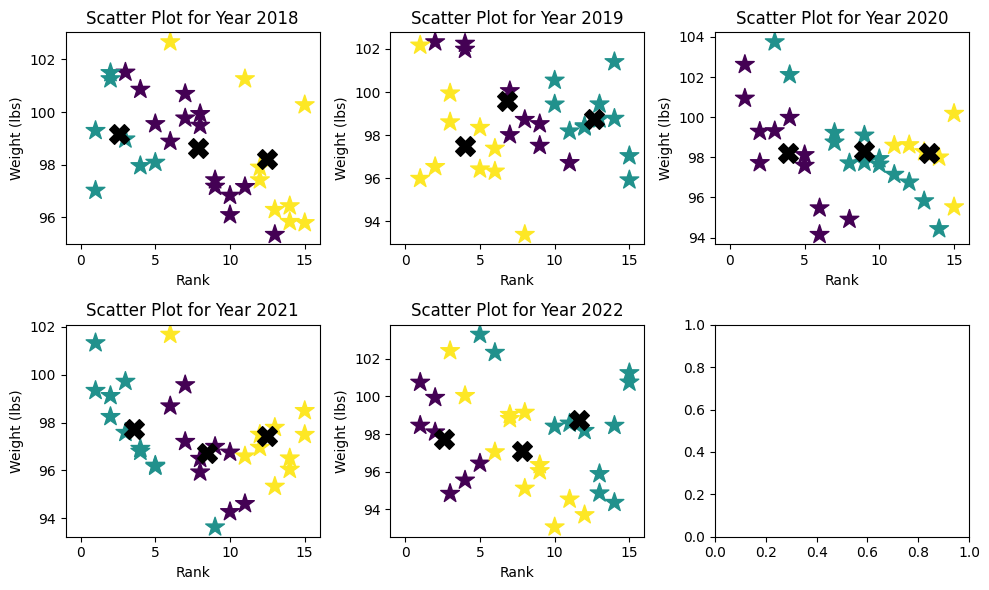

In [59]:
#--------------------------------------------------------------------------------#
import matplotlib.pyplot as plt

## Create lists to use for loop iteration for plotting
#  dataframes, contains all the dataframes for each year
#  clusters, contains all the clusters for each year
#  years, contains all the years

dataframes = [df_18, df_19, df_20, df_21, df_22]
clusters = [clusters_18, clusters_19, clusters_20, clusters_21, clusters_22]
centroids = [centroids_18, centroids_19, centroids_20, centroids_21, centroids_22]
years = [2018, 2019, 2020, 2021, 2022]

## Initialize Plot
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

## LOOP : Scatter Plot for each Year
for i, (year, dataframe) in enumerate(zip(years, dataframes)):
    ax = axes[i]
    ax.scatter(dataframe['Rank'], dataframe['Avg_Weight'], c=clusters[i], marker='*', s=200)
    ax.set_xlim(-1, 16)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Weight (lbs)")
    ax.set_title("Scatter Plot for Year " + str(year))

    #-- Plot Centroids --#
    c = centroids[i]
    ax.scatter(c[:, 0], c[:, 1], marker='X', c='black', s=200, label='Centroids')

plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------#

$\rule{27cm}{0.4pt}$ 
### k-Mean Analysis WEIGHT

In [55]:
#--------------------------------------------------------------------------------#
centroids_22, clusters_22, mean_error_22 = kMeans(df_22[["Rank", "Avg_Weight"]], k=3)
centroids_21, clusters_21, mean_error_21 = kMeans(df_21[["Rank", "Avg_Weight"]], k=3)
centroids_20, clusters_20, mean_error_20 = kMeans(df_20[["Rank", "Avg_Weight"]], k=3)
centroids_19, clusters_19, mean_error_19 = kMeans(df_19[["Rank", "Avg_Weight"]], k=3)
centroids_18, clusters_18, mean_error_18 = kMeans(df_18[["Rank", "Avg_Weight"]], k=3)
#--------------------------------------------------------------------------------#

### Plot the resulting Graph

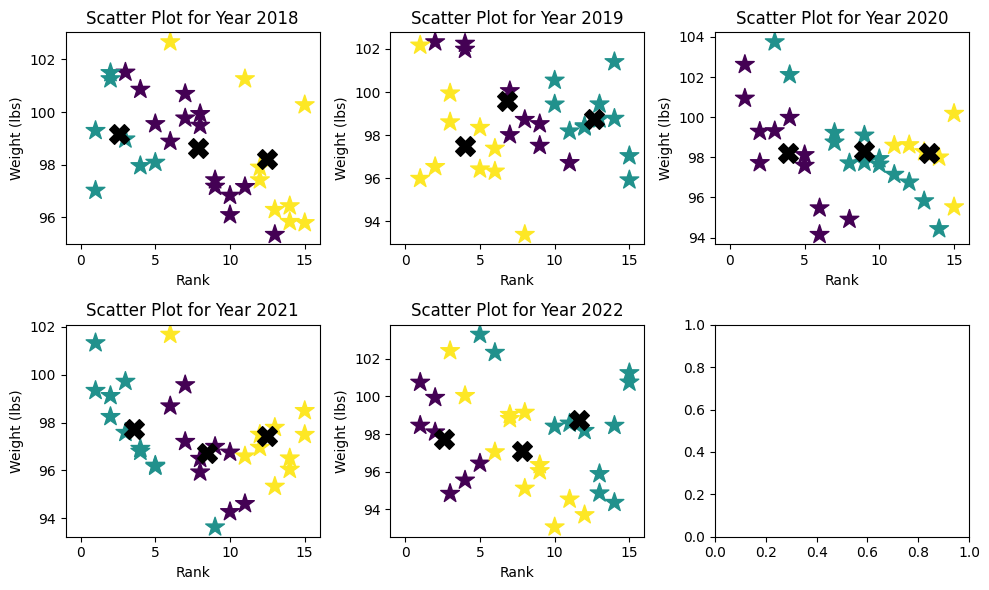

In [58]:
#--------------------------------------------------------------------------------#
import matplotlib.pyplot as plt

## Create lists to use for loop iteration for plotting
#  dataframes, contains all the dataframes for each year
#  clusters, contains all the clusters for each year
#  years, contains all the years

dataframes = [df_18, df_19, df_20, df_21, df_22]
clusters = [clusters_18, clusters_19, clusters_20, clusters_21, clusters_22]
centroids = [centroids_18, centroids_19, centroids_20, centroids_21, centroids_22]
years = [2018, 2019, 2020, 2021, 2022]

## Initialize Plot
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

## LOOP : Scatter Plot for each Year
for i, (year, dataframe) in enumerate(zip(years, dataframes)):
    ax = axes[i]
    ax.scatter(dataframe['Rank'], dataframe['Avg_Weight'], c=clusters[i], marker='*', s=200)
    ax.set_xlim(-1, 16)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Weight (lbs)")
    ax.set_title("Scatter Plot for Year " + str(year))

    #-- Plot Centroids --#
    c = centroids[i]
    ax.scatter(c[:, 0], c[:, 1], marker='X', c='black', s=200, label='Centroids')

plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------#

$\rule{27cm}{0.4pt}$ 
### Analysis

Simply by looking at the average height and weight of each team across the years, it seems to have little affect on their final ranking for the season.

I attribute this to a couple reasons
1. Most teams have tall players
2. Averaging the team could make two very different teams seem equal: one where are all more or less the average height, and one where there are lots of very tall and very short people.

If we were to take this a step further, I would compare the heights and weights of each player given their position. This would solve the issues above.

Furthermore, clustering is pretty useless on these plots. The higher ranked teams are clustered closer together than the lower ranked teams, but in most cases they have the same height or weight. So it appears that feature has little affect on the clustering.

### Improvement

Since it appears the average height and weight doesn't appear to be a strong indication of their final rank in the NBA, perhaps we can take the maximum height 